# MDH-CS Homogenous Bulk Model with Fixed Adsorption Scaling

In [1]:
from pylab import *
import scipy.constants as sc
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, curve_fit
from scipy import interpolate
import pandas as pd
import pickle
from pdb import set_trace as breakpoint

from post import lag_time

## Define Constants

In [2]:
τ = 1e-7 # s, 10 ps is optimal timescale from Xie et al. (2022)
tspan = [0, 40]
Kads = 3.4e4

In [3]:
enzyme = ['MDHf', 'MDHr', 'CS', 'CSm']
kcat = [31, 870, 88, 44]   # /s
KiA = array([0.42, 15, 4.6, 1.7]) # μM
KMA = array([0.13, 87, 7.9, 1.1]) # μM
KMB = array([0.83, 33, 21, 7.8])  # μM
kads = array([1/τ] * 4)

p = pd.DataFrame(dict(kcat=kcat, KiA=KiA, KMA=KMA, KMB=KMB, kads=kads),index=enzyme)

In [4]:
# μM, total enzyme concentration, adjusted to match 
# Fig 3 of Bulugoglu 2016
C = 0.1

C_MDH = C    # μM
CNAD0 = 2e3  # μM, NAD+
Cmal0 = 1e3  # μM, L-malate
CNADH0 = 0   # μM, NADH
Ccit0 = 0    # µM, citrate

C_CS = C       # μM
CaCoA0 = 0.1e3 # μM, a-CoA
COAA0 = 0    # µM, bulk OAA

p['Vmax'] = p['kcat'] * array([C_MDH, C_MDH, C_CS, C_CS]) # µM/s
p

,kcat,KiA,KMA,KMB,kads,Vmax
MDHf,31,0.42,0.13,0.83,10000000.0,3.1
MDHr,870,15.00,87.00,33.00,10000000.0,87.0
CS,88,4.60,7.90,21.00,10000000.0,8.8
CSm,44,1.70,1.10,7.80,10000000.0,4.4


## pure kinetics

In [5]:
def r_PPBB(CA, CB, p):
    
    Vmax, KiA, KA, KB = p.loc[['Vmax', 'KiA', 'KMA', 'KMB']]
    
    rate = Vmax * CA * CB / (KiA * KB + KB * CA + KA * CB + CA * CB) 
    return rate

In [6]:
v0 = r_PPBB(CNAD0, Cmal0, p.loc['MDHf'])
v0

3.097227441593031

In [7]:
def deq(t,x):
    
    CNADH, CA, CB, CC, CD = x
    
    v = r_PPBB(CA, CB, p = p.loc[ver])
    
    dCdt = [v0, v0 - v, 0, v, v] #OAA, acetyl-CoA, citrate, CoA
    
    return dCdt

## Import Data, Define Basins and Paths

### data from Bulutoglu et al. 2016

In [8]:
exp_rec = pd.read_csv('data/Bulutoglu2016/Recombinant.csv')
PRec = pd.read_csv('data/Bulutoglu2016/Prediction of Recombinant.csv')

exp_mut = pd.read_csv('data/Bulutoglu2016/Mutant.csv')
PMut = pd.read_csv('data/Bulutoglu2016/Prediction of Mutant.csv')

expx_r, expy_r = exp_rec['x'], exp_rec['y']
expx_m, expy_m = exp_mut['x'], exp_mut['y']

### import transition probability matrix from MSM

In [9]:
T_prob_rec = pd.read_pickle('data/Xie_2022/Recombinant/R_transition_matrix.pickle')
T_prob_mut = pd.read_pickle('data/Xie_2022/Mutant/M_transition_matrix.pickle')

ST = len(T_prob_rec)

### Node indices for each basin

In [10]:
SM1R = pd.read_pickle('data/Xie_2022/Recombinant/R_SM1_idx.pickle')
SM2R = pd.read_pickle('data/Xie_2022/Recombinant/R_SM2_idx.pickle')
SC1R = pd.read_pickle('data/Xie_2022/Recombinant/R_SC1_idx.pickle')
SC2R = pd.read_pickle('data/Xie_2022/Recombinant/R_SC2_idx.pickle')
des_idxr = pd.read_pickle('data/Xie_2022/Recombinant/R_des_idx.pickle')
int_idxr = pd.read_pickle('data/Xie_2022/Recombinant/R_int_idx.pickle')

In [11]:
SM1M = pd.read_pickle('data/Xie_2022/Mutant/M_SM1_idx.pickle')
SM2M = pd.read_pickle('data/Xie_2022/Mutant/M_SM2_idx.pickle')
SC1M = pd.read_pickle('data/Xie_2022/Mutant/M_SC1_idx.pickle')
SC2M = pd.read_pickle('data/Xie_2022/Mutant/M_SC2_idx.pickle')
des_idxm = pd.read_pickle('data/Xie_2022/Mutant/M_des_idx.pickle')
int_idxm = pd.read_pickle('data/Xie_2022/Mutant/M_int_idx.pickle')

In [12]:
# convert to list
SM1r, SM2r, SC1r, SC2r, surfr, bulkr = [
    list(b) for b in [SM1R, SM2R, SC1R, SC2R, int_idxr, des_idxr]
]

NSM1r, NSM2r, NSC1r, NSC2r = [len(b) for b in [SM1r, SM2r, SC1r, SC2r]]

# collect all MDH and CS residuals
MDHr = append(SM1r,SM2r)
CSr = append(SC1r,SC2r)

NMDHr, NCSr = len(MDHr),len(CSr)

In [13]:
# convert to list
SM1m, SM2m, SC1m, SC2m, surfm, bulkm = [
    list(b) for b in [SM1M, SM2M, SC1M, SC2M, int_idxm, des_idxm]
]

NSM1m, NSM2m, NSC1m, NSC2m = [len(b) for b in [SM1m, SM2m, SC1m, SC2m]]

# collect all MDH and CS residuals
MDHm = append(SM1m,SM2m)
CSm = append(SC1m,SC2m)

NMDHm, NCSm = len(MDHm),len(CSm)

## convert transition probability to transition rate matrix

In [14]:
Tr = (T_prob_rec - identity(ST))/τ
Tm = (T_prob_mut - identity(ST))/τ

## Differential Equation Function

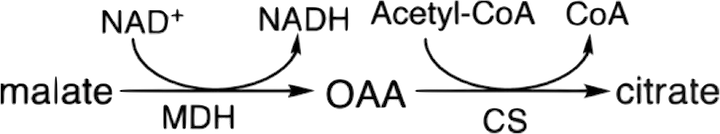

In [15]:
surf_all_r = SM1r + SM2r + SC1r + SC2r + surfr
surf_all_m = SM1m + SM2m + SC1m + SC2m + surfm

## Solver function

In [16]:
# function to package all solve_ivp and fitting steps together
def diffeq_solver(teval, u0, ST, T, p, C, ver, switches, idx, Kads): 
    
    '''
    teval: time, x-axis, 1D array
    u0: initial occupancy of network, θ, and concentration of substrates , y-axis, 1D array
    ST: number of nodes in network
    T: transition matrix
    p: rate constant data for enzyme, 1D array
    C: enzyme complex concentration
    ver: variation of CS - 'CS' or 'CSm' for recombinant or mutant
    switches: turn active sites on/off, 1 if on and 0 if off
    idx: array of active site indices, 6x1D array of varied lengths
    Kads: adsorption scaling factor
    '''
    # set switches
    swM1, swM2, swC1, swC2 = switches
    
    # pull out specific basin indices
    SM1, SM2, SC1, SC2, surf, bulk = idx
    surf_all = SM1 + SM2 + SC1 + SC2 + surf
    MDH = SM1 + SM2
    CS = SC1 + SC2
     
    NSM1, NSM2, NSC1, NSC2, Nsurf, Nsurf_all = [
        len(b) for b in [SM1, SM2, SC1, SC2, surf, surf_all]]
    
    MDH_tot = NSM1 + NSM2 # total number of possible MDH nodes
    CS_tot = NSC1 + NSC2 # total number of possible MDH nodes
    NMDH = swM1*NSM1 + swM2*NSM2 # only count MDH nodes that are turned on
    NCS = swC1*NSC1 + swC2*NSC2 # only count CS nodes that are turned on
    
    args = (SM1,SM2,SC1,SC2,surf_all,surf,bulk,MDH,CS,NMDH,NCS)

    tspan = [min(teval),max(teval)] 

    # reset diag of T for conservation
    T_surf_all = T[np.ix_(surf_all, surf_all)]
    T0 = np.copy(T_surf_all)
    np.fill_diagonal(T0,0)
    np.fill_diagonal(T_surf_all, -np.sum(T0,axis=1)) 
    
    # applicable kinetics at CS
    kcat, KiA, KA, KB = p.loc[ver,['kcat', 'KiA', 'KMA', 'KMB']]
    KM_app = (KiA*KB + KA*CaCoA0) / (KB+CaCoA0)
    kcat_app = kcat * CaCoA0 / (KB + CaCoA0)
    
    # Initialize adsorption and desorption
    kdes = zeros(ST)
    kads = zeros(ST)
    kads[surf_all] = np.sum(T[np.ix_(bulk, surf_all)],axis = 0)/Kads
    kdes[surf_all] = np.sum(T[np.ix_(surf_all, bulk)],axis = 1)
    
    def num_func(t,u): 

        '''
        t: time, x-axis, 1D array
        u: occupancy of network, θ, and concentration of substrates , y-axis, 1D array
        '''

        # import values of θ, L-malate, NAD+, NADH, a-COA, bulk OAA, Citrate
        θ = u[:ST]
        Cmal, CNAD, CNADH, CaCoA, COAA, Ccit = u[ST:]

        # initialize node occupancy differential equations
        dθdt = np.zeros_like(θ) #np.matmul(θ,T)

        # surface transport
        dθdt[surf_all] = np.matmul(θ[surf_all],T_surf_all)

        ## reaction at MDH (SM1, SM2)

        # add OAA production to MDH basin equations 
        # consider only the forward reaction (rMDHf)
        rMDHf = r_PPBB(Cmal, CNAD, p.loc['MDHf'])/C
        #r_PPBB(CA, CB, p)
        rSM1 = rMDHf * NSM1/MDH_tot 
        rSM2 = rMDHf * NSM2/MDH_tot 

        rMDH = swM1 * rSM1 + swM2 * rSM2

        # add OAA production to MDH basin equations 
        # split the forward reaction between MDH states
        dθdt[SM1] += swM1 * rSM1 / NSM1  
        dθdt[SM2] += swM2 * rSM2 / NSM2  

        ## reaction at CS (SC1, SC2)

        rCStot = kcat_app * (swC1*np.sum(θ[SC1]) + swC2*np.sum(θ[SC2])) 
        rSC1 = rCStot * NSC1/NCS
        rSC2 = rCStot * NSC2/NCS

        rCS = swC1 * rSC1 + swC2 * rSC2

        # add OAA consumption to CS basin equations 
        # split the reaction between CS states  
        dθdt[SC1] -= swC1 * rSC1 / NSC1 
        dθdt[SC2] -= swC2 * rSC2 / NSC2 

        # desorption rate from each surface state to the bulk
        rdes = kdes * θ #* (θ > 0)
        rdes[CS] = kdes[CS] * np.sum(θ[CS]) / NCS

        # adsorption rate from the bulk to each surface state
        rads = kads * (1 - θ) * COAA / C
        rads[CS] = kads[CS] * (1 - np.sum(θ[CS])) * COAA / C 

        dθdt += rads - rdes

        # update rate equations for bulk species concentrations
        dCmaldt  = 0 
        dCNADdt  = 0
        dCNADHdt = C * rMDH 
        dCaCoAdt = 0
        dCOAAdt  = C * sum(rdes - rads)
        dCCoAdt  = C * rCS

        dCdt =  np.array([dCmaldt, dCNADdt, dCNADHdt, dCaCoAdt, dCOAAdt, dCCoAdt])    

        dudt = np.append(dθdt,dCdt)

        return dudt
        
    sol = solve_ivp(num_func, tspan, u0, method = 'Radau', t_eval = teval)
        
    return sol

# Recombinant case

In [17]:
# set version of CS enzyme, 'CS' or 'CSm'
ver = 'CS' 

## Pure Kinetic Model

In [18]:
teval = linspace(*tspan,1000)

C0 = [0,0,CaCoA0,0,0] #OAA, acetyl-CoA, citrate, CoA

sol_rec = solve_ivp(deq, tspan, C0, method = 'Radau', t_eval = teval)
C_NADH_rk, C_OAA_rk,  C_aCoA_rk, C_cit_rk, C_CoA_rk = sol_rec.y

## Initial Conditions

In [19]:
# initial node occupancies
θ0 = zeros(ST) # initial condition zeros for all network node occupancy 
C0 = [Cmal0, CNAD0, CNADH0, CaCoA0, COAA0, Ccit0]
u0 = append(θ0,C0)

## Baseline Mixed Solution

In [20]:
teval = linspace(*tspan,1000)
swM1, swM2, swC1, swC2 = [1,1,1,1]
idxr = [SM1r, SM2r, SC1r, SC2r, surfr, bulkr]
    
solr = diffeq_solver(teval, u0, ST, Tr, p, C, ver, [swM1, swM2, swC1, swC2], idx = idxr, Kads = Kads)

## Postprocess

In [21]:
θr = solr.y[:ST]
Cmalr, CNADr, CNADHr, CaCoAr, COAAr, CCoAr = solr.y[ST:]

CIsr = C * sum(θr, axis=0)
Ctotr = COAAr + CCoAr + CIsr

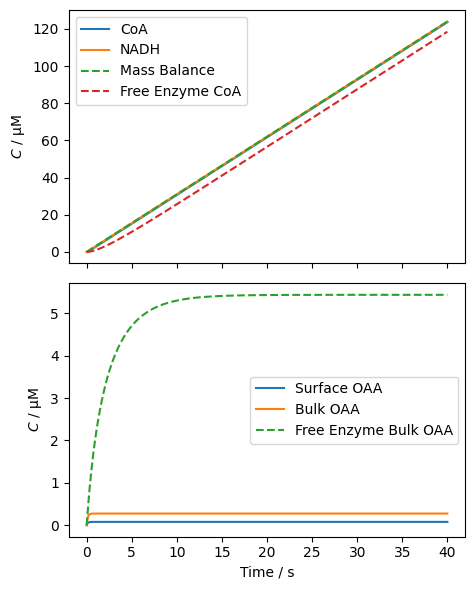

In [22]:
fig, ax = subplots(2,1,figsize=3*array([1.618,2]), sharex=True)

sca(ax[0])
plot(teval, CCoAr)
plot(teval, CNADHr)
plot(teval, Ctotr, '--')
plot(teval, C_CoA_rk, '--')
ylabel('$C$ / µM')
legend(['CoA','NADH','Mass Balance','Free Enzyme CoA'])

sca(ax[1])
plot(teval, CIsr, teval, COAAr)
plot(teval, C_OAA_rk, '--')
xlabel('Time / s')
ylabel('$C$ / µM')
legend(['Surface OAA', 'Bulk OAA', 'Free Enzyme Bulk OAA'])

tight_layout()
show()

### Lag Time

In [23]:
ltr = lag_time(teval, CCoAr, frac=0.3)
lagr = ltr['lag_time']
errr = ltr['lag_error']
print(f'the lag time of the recombinant complex is {lagr:.2} ± {errr:.2} s')

the lag time of the recombinant complex is 0.11 ± 1.3e-10 s


# Mutant Case

In [24]:
# set version of CS enzyme, 'CS' or 'CSm'
ver = 'CSm' 

## Pure Kinetic Model

In [25]:
teval = linspace(*tspan,1000)

C0 = [0,0,CaCoA0,0,0] #OAA, acetyl-CoA, citrate, CoA

sol_mut = solve_ivp(deq, tspan, C0, method = 'Radau', t_eval = teval)
C_NADH_mk, C_OAA_mk,  C_aCoA_mk, C_cit_mk, C_CoA_mk = sol_mut.y

## Network Model

In [26]:
teval = linspace(*tspan,1000)
swM1, swM2, swC1, swC2 = [1,1,1,1]
idxm = [SM1m, SM2m, SC1m, SC2m, surfm, bulkm]
    
solm = diffeq_solver(teval, u0, ST, Tm, p, C, ver, [swM1, swM2, swC1, swC2], idx = idxm, Kads = Kads)

## Postprocess

In [27]:
θm = solm.y[:ST]
Cmalm, CNADm, CNADHm, CaCoAm, COAAm, CCoAm = solm.y[ST:]

CIsm = C * sum(θm, axis=0)
Ctotm = COAAm + CCoAm + CIsm

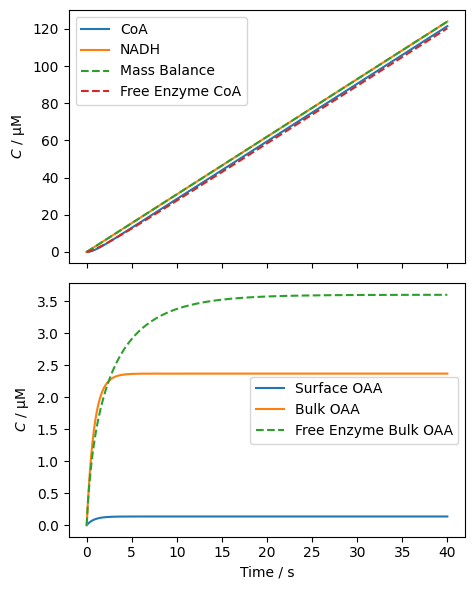

In [28]:
fig, ax = subplots(2,1,figsize=3*array([1.618,2]), sharex=True)

sca(ax[0])
plot(teval, CCoAm)
plot(teval, CNADHm)
plot(teval, Ctotm, '--')
plot(teval, C_CoA_mk, '--')
ylabel('$C$ / µM')
legend(['CoA','NADH','Mass Balance','Free Enzyme CoA'])

sca(ax[1])
plot(teval, CIsm, teval, COAAm)
plot(teval, C_OAA_mk, '--')
xlabel('Time / s')
ylabel('$C$ / µM')
legend(['Surface OAA', 'Bulk OAA', 'Free Enzyme Bulk OAA'])

tight_layout()
show()

### Lag Time

In [29]:
ltm = lag_time(teval, CCoAm, frac=0.3)
lagm = ltm['lag_time']
errm = ltm['lag_error']
print(f'the lag time of the mutant complex is {lagm:.2} ± {errm:.2} s')

the lag time of the mutant complex is 0.81 ± 4.6e-09 s


## Comparison to Bulutoglu 2016

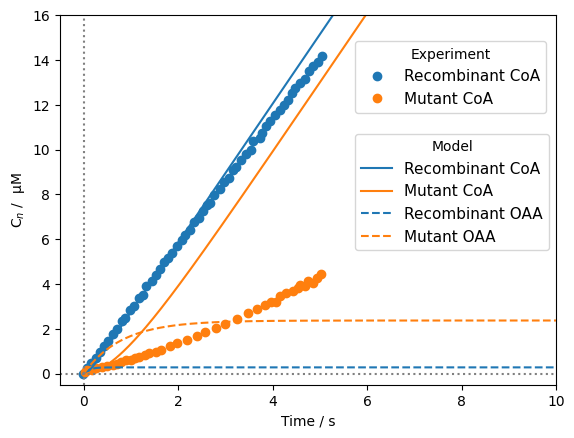

In [30]:
fig, ax = subplots()
line1 = plot(expx_r, expy_r, 'o', color='C0', label='Recombinant CoA')
line2 = plot(expx_m, expy_m, 'o', color= 'C1', label='Mutant CoA')
plot(teval, CCoAr, color='C0', label='Recombinant CoA')
plot(teval, CCoAm, color='C1', label='Mutant CoA')
plot(teval, COAAr, '--',color='C0', label='Recombinant OAA')
plot(teval, COAAm, '--',color='C1', label='Mutant OAA')
axhline(0, color='gray', linestyle=':')
axvline(0, color='gray', linestyle=':')

xlabel('Time / s')
ylabel('C$_n$ /  µM')
xlim(-0.5,10)
ylim(-0.5,16)
legend2 = legend(handles = ax.lines[2:6],title = 'Model',
                 fontsize=11, loc='upper left', bbox_to_anchor=(0.58, 0.7))
legend1 = legend(handles = ax.lines[:2],title = 'Experiment',
       loc='upper left', bbox_to_anchor=(0.58, 0.95), fontsize=11)
ax.add_artist(legend2)
show()